In [1]:
# Setup project name and directory.
## Project name is a global variable, and will prefix all output files.
## Project name directory is created within current directory.
def setup_project(name, create_subdirectory = False):
    if create_subdirectory == True: 
        import os
        os.mkdir(os.path.expanduser(name))
    global project_name
    project_name = name

# Raw Data from CSV
## In: CSV file, with any number of columns, first row must have column names.
## Out: Two dicts, one keyed Attributes, has a list of column names; the other keyed Content has integer keys, each entry is itself a dict of row values, keyed by column names.
def raw_data_from_CSV(csv_file, delimiter_character):
    raw_data = {}
    import csv
    with open(csv_file) as file:
        data = csv.reader(file, delimiter = delimiter_character)
        j = 0
        for i in data: 
            if j == 0: 
                attribute_names = i
            if j > 0:
                raw_data[j-1] = dict()
                for k in range(0,len(attribute_names)):
                    raw_data[j-1][attribute_names[k]] = i[k]
            j = j + 1
    return { 'Attributes': attribute_names, 'Content': raw_data }

# Shorten input string to n characters and ellipsis '...'.
def shorten_string(string, n):
    if len(string) < n: return string
    else: return string[0:n] + '...'

# Structure raw data.
## In: raw, which is the output of raw_data_from_CSV.
## Out: Dict, where each item is one item from raw, with a series of properties describing that item. 
## Note: In Out, properties are selected so as to preserve the information in the structure of raw. 
## For example, if two items were in the same key in raw (same row in the original CSV), 
## then there must be a relationship over them, in Out.
def structure_raw_data(raw):
    o = dict()
    r = dict()
    id_c = 1
    ats = raw['Attributes']
    for c in raw['Content']:
        for a1 in ats:
            # Unary properties.
            item_id = 'n_' + str(id_c)
            id_c = id_c + 1
            full_name = raw['Content'][c][a1]
            
            # Relationships that d['Content'][c][a1] is involved in.
            d_c_a1 = dict()
            r[raw['Content'][c][a1]] = d_c_a1
            
            for a2 in ats:
                if a1 != a2: d_c_a1[a1,a2] = (full_name, raw['Content'][c][a2])
            
            # Add entry for d['Content'][c][a1] to o.
            o[item_id] = { 'uid': item_id, 
                          'nickname': shorten_string(full_name, 15), 
                          'full_name': full_name, 
                          'instance_of': a1, 
                          'relationships':  d_c_a1 }
    return o

# Make a multi digraph that only has all edges of one relationship type.
## In: d is output of structure_raw_data, rel_from is the name of the type of origin node, and rel_to is the type of destination node.
def make_rel_net(d, rel_from, rel_to):
    global nx
    import networkx as nx
    rel_net = nx.MultiDiGraph()
    for i in d:
        for j in d[i]['relationships']:
            if j == (rel_from, rel_to): 
                rel_net.add_edge(d[i]['relationships'][j][0], d[i]['relationships'][j][1])
    return rel_net

In [2]:
setup_project('SRN')

In [3]:
d = raw_data_from_CSV('raw_data/ilang_SRN_data.csv', ',') 

In [4]:
sd = structure_raw_data(d)

In [5]:
td = make_rel_net(sd, 'Definiens', 'Definiendum')

In [88]:
# pos = nx.spring_layout(td, k=20)

# position nodes
import math
n_pos = dict()
y = 1
s = 1 + max(dict(td.in_degree()).values())
for e in td.edges():
    n_pos[e[0]] = [td.in_degree()[e[0]], y]
    n_pos[e[1]] = [td.in_degree()[e[1]], y]
    y = y + s

In [89]:
# # label nodes with uid
# n_labels = dict()
# for i in sd:
#     for n in td.nodes():
#         if n == sd[i]['full_name']:
#             n_labels[sd[i]['full_name']] = sd[i]['uid']

In [90]:
def add_line_breaks(x, max_chars):
    import math
    y = str()
    cc = 0
    for i in x.split(): 
        cc = cc + len(i)
        y = y + ' ' + i
        if cc > max_chars:
            cc = 0
            y = y + '\n'
    return y

In [91]:
# label nodes with full_name, newline every 30 characters
n_labels = dict()
for i in sd:
    for n in td.nodes():
        if n == sd[i]['full_name']:
            n_labels[sd[i]['full_name']] = add_line_breaks(sd[i]['full_name'], 30)

In [92]:
# offset node labels from node positions
pos_node_labels = dict()
for i in n_pos: pos_node_labels[i] = [n_pos[i][0], n_pos[i][1]+1]

In [93]:
# color nodes
colored_nodes = list()
for i in td.nodes():
    if td.in_degree()[i] == 0:
        colored_nodes.append('#DDDDDD')
    if td.in_degree()[i] > 0:
        colored_nodes.append('#FF9900')

In [94]:
edgelabels = dict()
for e in td.edges(): edgelabels[e] = 'defines'

{('Smart Retail Network software.', 'SRN'): Text(0.5,1,'defines'),
 ('Shop Display Management software.', 'SDM'): Text(0.5,3,'defines'),
 ('Object installed at a POP, which is used to promote products; Shop Display is synonym with Fixture.',
  'Shop Display'): Text(0.5,5,'defines'),
 ('A Shop Display which cannot itself be subdivided.',
  'Basic Shop Display'): Text(0.5,7,'defines'),
 ('A Shop Display made from two or more Basic Shop Displays.',
  'Complex Shop Display'): Text(0.5,9,'defines'),
 ('Unique numeric identifier generated by SDM for each BSD, used to identify a BSD when a QR code scanner is not available.',
  'Shop Display Identifier'): Text(0.5,11,'defines'),
 ('Representative of the company supplying Shop Displays.',
  'Shop Display Supplier'): Text(0.5,13,'defines'),
 ('Location (shop) where products are being sold.',
  'Point of Purchase'): Text(0.5,15,'defines'),
 ('An individual visiting a POP and collecting data about the POP; an FMR typically gets a list of POP to vi

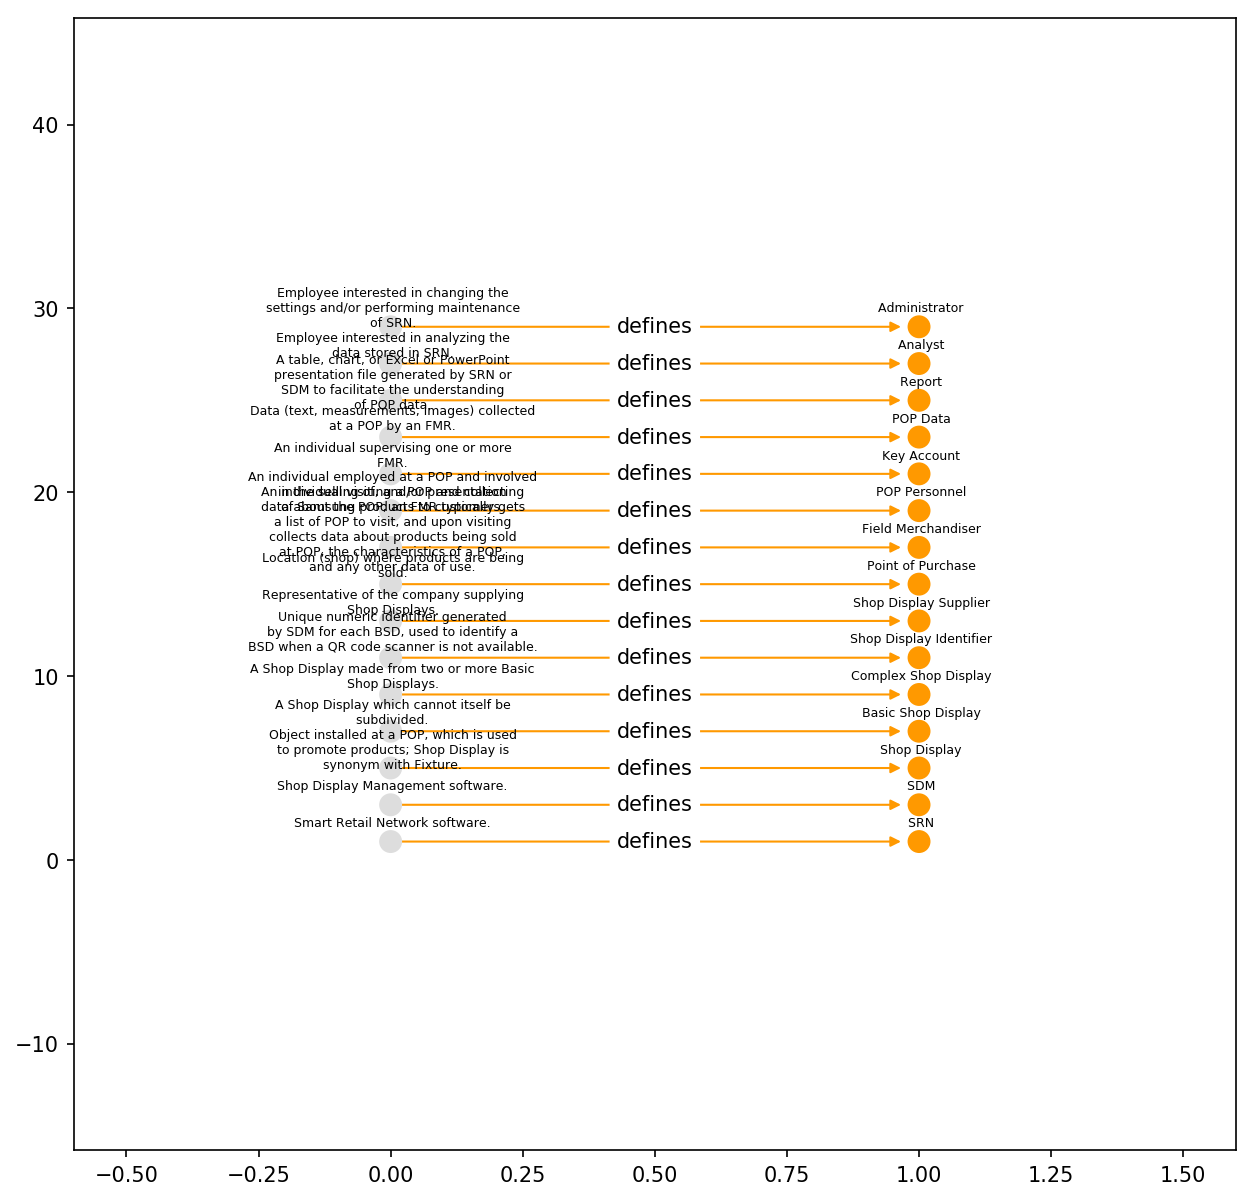

In [96]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# Draw the subnet
plt.figure(num=None, figsize=(10, 10), dpi=150, facecolor='w', edgecolor='g')
plt.margins(0.5)
# plt.grid(b = None, linestyle = 'dotted')
nx.draw_networkx_nodes(td, n_pos, node_color = colored_nodes, node_shape = 'o', node_size = 100)
nx.draw_networkx_labels(td, pos = pos_node_labels, labels = n_labels, font_size = 6)
nx.draw_networkx_edges(td, n_pos, edge_color = '#FF9900')
nx.draw_networkx_edge_labels(td, n_pos, edge_labels = edgelabels)

# nx.draw(td, pos, node_list = your_subgraph.nodes(), edgelist = your_subgraph.edges(), 
#         labels = node_labels_short, arrows=True, with_labels=True, 
#         node_color = node_colors_list, edge_color = edge_colors_list)

# # Save image as PNG file.
# image_file_name = "%s_Subgraph_%s.png" % (analysis_project_name, filename_suffix)
# plt.savefig(image_file_name)
# print('Sub-network image filename:', image_file_name)